In [50]:
import sys
sys.path.append("/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/code")

In [53]:
import os
import re 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import manifold
from unionfind import unionfind
from sklearn.cluster import KMeans,OPTICS,DBSCAN
import sklearn
import matplotlib.cm as cm
import package
import torch

## Utilitaries

In [2]:
def display(states,li_titles):
    
    # setting values to rows and column variables
    n = len(states)
    rows = n // 5 + 1
    columns = 5
    fig = plt.figure(figsize=(15, rows * 3))
    
    for i in range(n):
        fig.add_subplot(rows, columns, i+1)
        # showing image
        plt.imshow(states[i])
        plt.title(i)
        plt.axis('off')

In [3]:
dfc = np.load('/neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs/inputs.npy')
meta = pd.read_csv("/neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs/metadata.tsv", sep="\t")
dfc_win = dfc[meta["condition"].isin(['awake','light-propofol','deep-propofol'])].reshape(-1,464,82,82)

In [4]:
graph = np.load("/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/data/DistanceMatrices/light-propofol_deep-propofol_awake/distances.npy")

In [5]:
dico = {"light-propofol" : 0, "deep-propofol" : 1, "awake" : 2}

In [6]:
labels_session = np.array([meta["condition"].iloc[i*464] for i in range(len(meta)//464)])
labels_subject = np.array([meta["monkey"].iloc[i*464] for i in range(len(meta)//464)])
labels_date = np.array([meta["session"].iloc[i*464] for i in range(len(meta)//464)])
id_sessions = np.argwhere(np.isin(labels_session,["light-propofol","deep-propofol","awake"])).flatten()
labels_session = labels_session[id_sessions]
labels_subject = labels_subject[id_sessions]
labels_date = labels_date[id_sessions]

In [7]:
li_indices_awake = np.argwhere(labels_session == "awake").flatten()
li_indices_light_propofol = np.argwhere(labels_session == "light-propofol").flatten()
li_indices_deep_propofol = np.argwhere(labels_session == "deep-propofol").flatten()

# PLOT HISTOGRAMS

(array([  2.,   2.,   1.,   8.,  17.,  55., 148., 260., 197.,  60.]),
 array([0.6608641 , 0.68784137, 0.71481864, 0.7417959 , 0.76877317,
        0.79575044, 0.82272771, 0.84970498, 0.87668224, 0.90365951,
        0.93063678]),
 <BarContainer object of 10 artists>)

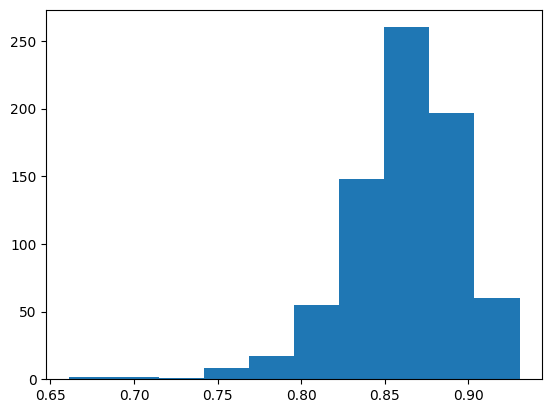

In [44]:
values = np.array([np.mean(graph[i,:,j,:]) for i in li_indices_deep_propofol for j in li_indices_light_propofol])
plt.hist(values,bins=10)

(array([  6.,  10.,  30.,  90., 138., 170., 116.,  28.,   8.,   4.]),
 array([0.96956187, 0.97770384, 0.9858458 , 0.99398777, 1.00212973,
        1.0102717 , 1.01841366, 1.02655563, 1.03469759, 1.04283956,
        1.05098152]),
 <BarContainer object of 10 artists>)

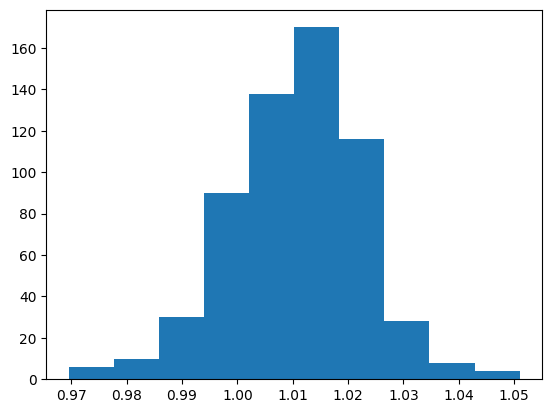

In [47]:
values = np.array([np.max(graph[i,:,j,:]) for i in li_indices_light_propofol for j in li_indices_light_propofol if i != j])
plt.hist(values,bins=10)

(array([  9.,  71., 228., 244., 138.,  56.,  18.,   7.,   3.,   1.]),
 array([0.99066412, 1.00204189, 1.01341965, 1.02479742, 1.03617518,
        1.04755294, 1.05893071, 1.07030847, 1.08168623, 1.093064  ,
        1.10444176]),
 <BarContainer object of 10 artists>)

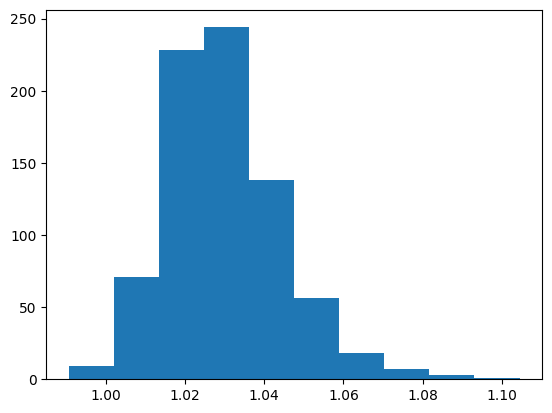

In [45]:
values = np.array([np.max(graph[i,:,j,:]) for i in li_indices_awake for j in li_indices_light_propofol])
plt.hist(values,bins=10)

In [18]:
X = graph[0,:,0,:].reshape(464,464)

In [16]:
accu = np.dstack(np.unravel_index(np.argsort(graph[0,0,:,:].ravel()), (86, 464)))[0,:,:]
closest_session = accu[accu[:,0] != 0]
print(closest_session)

[[ 18  96]
 [ 18  95]
 [ 18  97]
 ...
 [ 44 456]
 [ 44 455]
 [ 44 454]]


In [8]:
transitions_list = []
closest_idx = np.zeros((86,464,2))
closest_dist = np.zeros((86,464))
for session in range(86):
    li2 = []
    for i in range(464):
        accu = np.dstack(np.unravel_index(np.argsort(graph[session,i,:,:].ravel()), (86, 464)))[0,:,:]
        closest_session,closest_win = accu[accu[:,0] != session][0,:]
        closest_idx[session,i,:] = np.array([closest_session,closest_win])
        closest_dist[session,i] = graph[session,i,closest_session,closest_win]
    #transitions_list.append((session,np.argmax(np.bincount(li))))
    #print(session,np.flip(np.argsort(np.bincount(li)))[:5],np.flip(np.sort(np.bincount(li)))[:5],labels_session[session])

In [78]:
transitions_list

[(0, 1),
 (1, 0),
 (2, 3),
 (3, 2),
 (4, 8),
 (5, 7),
 (6, 7),
 (7, 6),
 (8, 4),
 (9, 10),
 (10, 11),
 (11, 10),
 (12, 13),
 (13, 14),
 (14, 13),
 (15, 7),
 (16, 8),
 (17, 18),
 (18, 16),
 (19, 21),
 (20, 18),
 (21, 17),
 (22, 27),
 (23, 24),
 (24, 27),
 (25, 27),
 (26, 24),
 (27, 24),
 (28, 24),
 (29, 24),
 (30, 29),
 (31, 32),
 (32, 31),
 (33, 47),
 (34, 33),
 (35, 48),
 (36, 47),
 (37, 36),
 (38, 70),
 (39, 51),
 (40, 47),
 (41, 47),
 (42, 47),
 (43, 48),
 (44, 47),
 (45, 47),
 (46, 44),
 (47, 45),
 (48, 49),
 (49, 48),
 (50, 53),
 (51, 53),
 (52, 69),
 (53, 44),
 (54, 53),
 (55, 44),
 (56, 59),
 (57, 59),
 (58, 59),
 (59, 58),
 (60, 59),
 (61, 59),
 (62, 59),
 (63, 59),
 (64, 65),
 (65, 44),
 (66, 33),
 (67, 68),
 (68, 69),
 (69, 68),
 (70, 38),
 (71, 69),
 (72, 68),
 (73, 69),
 (74, 75),
 (75, 74),
 (76, 77),
 (77, 76),
 (78, 79),
 (79, 78),
 (80, 81),
 (81, 51),
 (82, 83),
 (83, 82),
 (84, 85),
 (85, 84)]

## GRAPH

In [98]:
union = unionfind.UnionFind(np.arange(86))
for elem in transitions_list:
    union.union(elem[0],elem[1])

In [99]:
union.components()

[{0, 1},
 {33,
  34,
  36,
  37,
  39,
  40,
  41,
  42,
  44,
  45,
  46,
  47,
  50,
  51,
  53,
  54,
  55,
  64,
  65,
  66,
  80,
  81},
 {2, 3},
 {35, 43, 48, 49},
 {4, 8, 16, 17, 18, 19, 20, 21},
 {5, 6, 7, 15},
 {38, 70},
 {52, 67, 68, 69, 71, 72, 73},
 {9, 10, 11},
 {74, 75},
 {12, 13, 14},
 {76, 77},
 {78, 79},
 {82, 83},
 {84, 85},
 {22, 23, 24, 25, 26, 27, 28, 29, 30},
 {56, 57, 58, 59, 60, 61, 62, 63},
 {31, 32}]

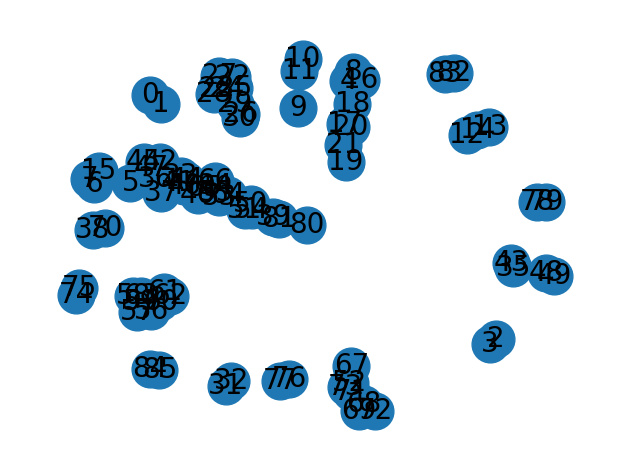

In [80]:
import networkx as nx

G = nx.DiGraph()

edges = transitions_list

for edge in edges : 
    G.add_edge(edge[0], edge[1])

pos = nx.spring_layout(G, seed=7)

# nodes
nx.draw_networkx_nodes(G, pos, node_size=700)

# edges
nx.draw_networkx_edges(G, pos, edgelist=transitions_list, width=3, arrowstyle="->",arrowsize=10)

# node labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
# edge weight labels
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

In [89]:
labels_date

array([20130830, 20130830, 20140314, 20140314, 20120824, 20120824,
       20120824, 20120824, 20120824, 20120907, 20120907, 20120907,
       20120907, 20120907, 20120907, 20120907, 20120928, 20121026,
       20121109, 20121116, 20121214, 20130531, 20120928, 20121026,
       20121109, 20121116, 20121214, 20130524, 20130531, 20140314,
       20150123, 20120421, 20120421, 20120420, 20120420, 20120427,
       20120427, 20120608, 20120608, 20120623, 20120629, 20120629,
       20120720, 20120720, 20120414, 20120414, 20120420, 20120420,
       20120505, 20120505, 20120608, 20120608, 20120623, 20120629,
       20120720, 20120720, 20120302, 20120302, 20120316, 20120316,
       20120323, 20120323, 20120413, 20120413, 20120128, 20120128,
       20120202, 20120202, 20120302, 20120302, 20120324, 20120324,
       20120413, 20120413, 20110722, 20110722, 20111217, 20111217,
       20120107, 20120107, 20120310, 20120310, 20120316, 20120316,
       20120323, 20120323])

In [84]:
labels_subject

array(['almira', 'almira', 'almira', 'almira', 'jade', 'jade', 'jade',
       'jade', 'jade', 'jade', 'jade', 'jade', 'jade', 'jade', 'jade',
       'jade', 'jade', 'jade', 'jade', 'jade', 'jade', 'jade', 'khali',
       'khali', 'khali', 'khali', 'khali', 'khali', 'khali', 'khali',
       'khali', 'jade', 'jade', 'khali', 'khali', 'khali', 'khali',
       'khali', 'khali', 'khali', 'khali', 'khali', 'khali', 'khali',
       'rana', 'rana', 'rana', 'rana', 'rana', 'rana', 'rana', 'rana',
       'rana', 'rana', 'rana', 'rana', 'jade', 'jade', 'jade', 'jade',
       'jade', 'jade', 'jade', 'jade', 'khali', 'khali', 'khali', 'khali',
       'khali', 'khali', 'khali', 'khali', 'khali', 'khali', 'rana',
       'rana', 'rana', 'rana', 'rana', 'rana', 'rana', 'rana', 'rana',
       'rana', 'rana', 'rana'], dtype='<U6')

[53. 60.]
0.20606732368469238


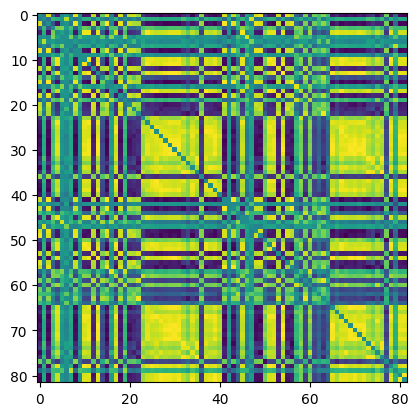

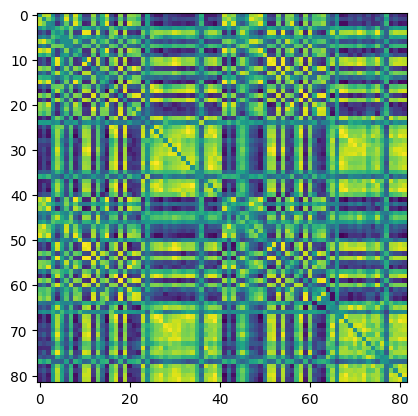

In [41]:
session,win = 47,328
print(closest_idx[session,win])
print(graph[session,win,int(closest_idx[session,win,0]),int(closest_idx[session,win,1])])
plt.imshow(dfc_win[session,win,:,:])
plt.show()
plt.imshow(dfc_win[int(closest_idx[session,win,0]),int(closest_idx[session,win,1]),:,:])

In [42]:
np.mean(np.abs(dfc_win[session,win,:,:]))

0.3928189967729402

In [43]:
np.mean(np.abs(dfc_win[53,60,:,:]))

0.34282290823595407

# Compute graphs

In [92]:
def compute_rise_graph():
    representative = np.zeros((86,464,2))
    for session in range(86):
        for win in range(464):
            accu = 0
            accu_session,accu_win = closest_idx[session,win].astype(int)
            while np.mean(np.abs(dfc_win[accu_session,accu_win,:,:])) > accu :
                accu = np.mean(np.abs(dfc_win[accu_session,accu_win,:,:]))
                accu_session,accu_win = closest_idx[accu_session,accu_win].astype(int)
            representative[session,win] = np.array([accu_session,accu_win])
    return representative

In [93]:
repre2 = compute_rise_graph().reshape(-1,2)
repre2_unique = []
for i in range(repre2.shape[0]):
    if not((repre2[i,0],repre2[i,1]) in repre2_unique):
        repre2_unique.append((int(repre2[i,0]),int(repre2[i,1])))

In [94]:
len(repre2_unique)

1035

In [33]:
def compute_graph_states(states):
    graph_states = np.zeros((len(states),len(states)))
    for i in range(len(states)):
        for j in range(len(states)):
            graph_states[i,j] = graph[states[i][0],states[i][1],states[j][0],states[j][1]]
    return graph_states

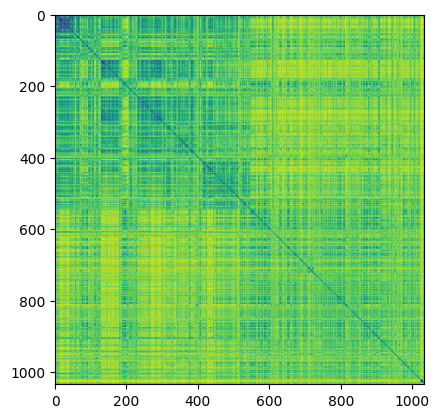

In [99]:
graph_states = compute_graph_states()
plt.imshow(graph_states)

In [124]:
def compute_local_min_graph():
    states = []
    for session in range(86):
        print(session)
        for win in range(464):
            list_neighbors = np.dstack(np.unravel_index(np.argsort(graph[session,win,:,:].ravel()), (86, 464)))[0,:,:][:100]
            accu = np.mean(np.abs(dfc_win[session,win,:,:]))
            flag = True
            for elem in list_neighbors :
                if accu <  np.mean(np.abs(dfc_win[elem[0],elem[1],:,:])):
                    flag = False
                    break
            if flag : 
                states.append([session,win])
    return states

In [125]:
states = compute_local_min_graph()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85


In [12]:
graph_states = compute_graph_states(new_states)
plt.imshow(graph_states)

NameError: name 'compute_graph_states' is not defined

In [31]:
states = np.load("/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/data/BrainStates/awake_deep-propofol_light-propofol/states.npy")
mat_states = np.concatenate([dfc_win[states[i][0],states[i][1],:,:].reshape(-1,82,82) for i in range(len(states))],axis = 0)
states = states[np.flip(np.argsort(np.mean(np.mean(np.abs(mat_states),axis = -1),axis = -1)))]
mat_states = mat_states[np.flip(np.argsort(np.mean(np.mean(np.abs(mat_states),axis = -1),axis = -1)))]

In [32]:
np.save("/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/data/BrainStates/awake_deep-propofol_light-propofol/states",arr = np.array(states))
np.save("/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/data/BrainStates/awake_deep-propofol_light-propofol/mat_states.npy",arr = mat_states)

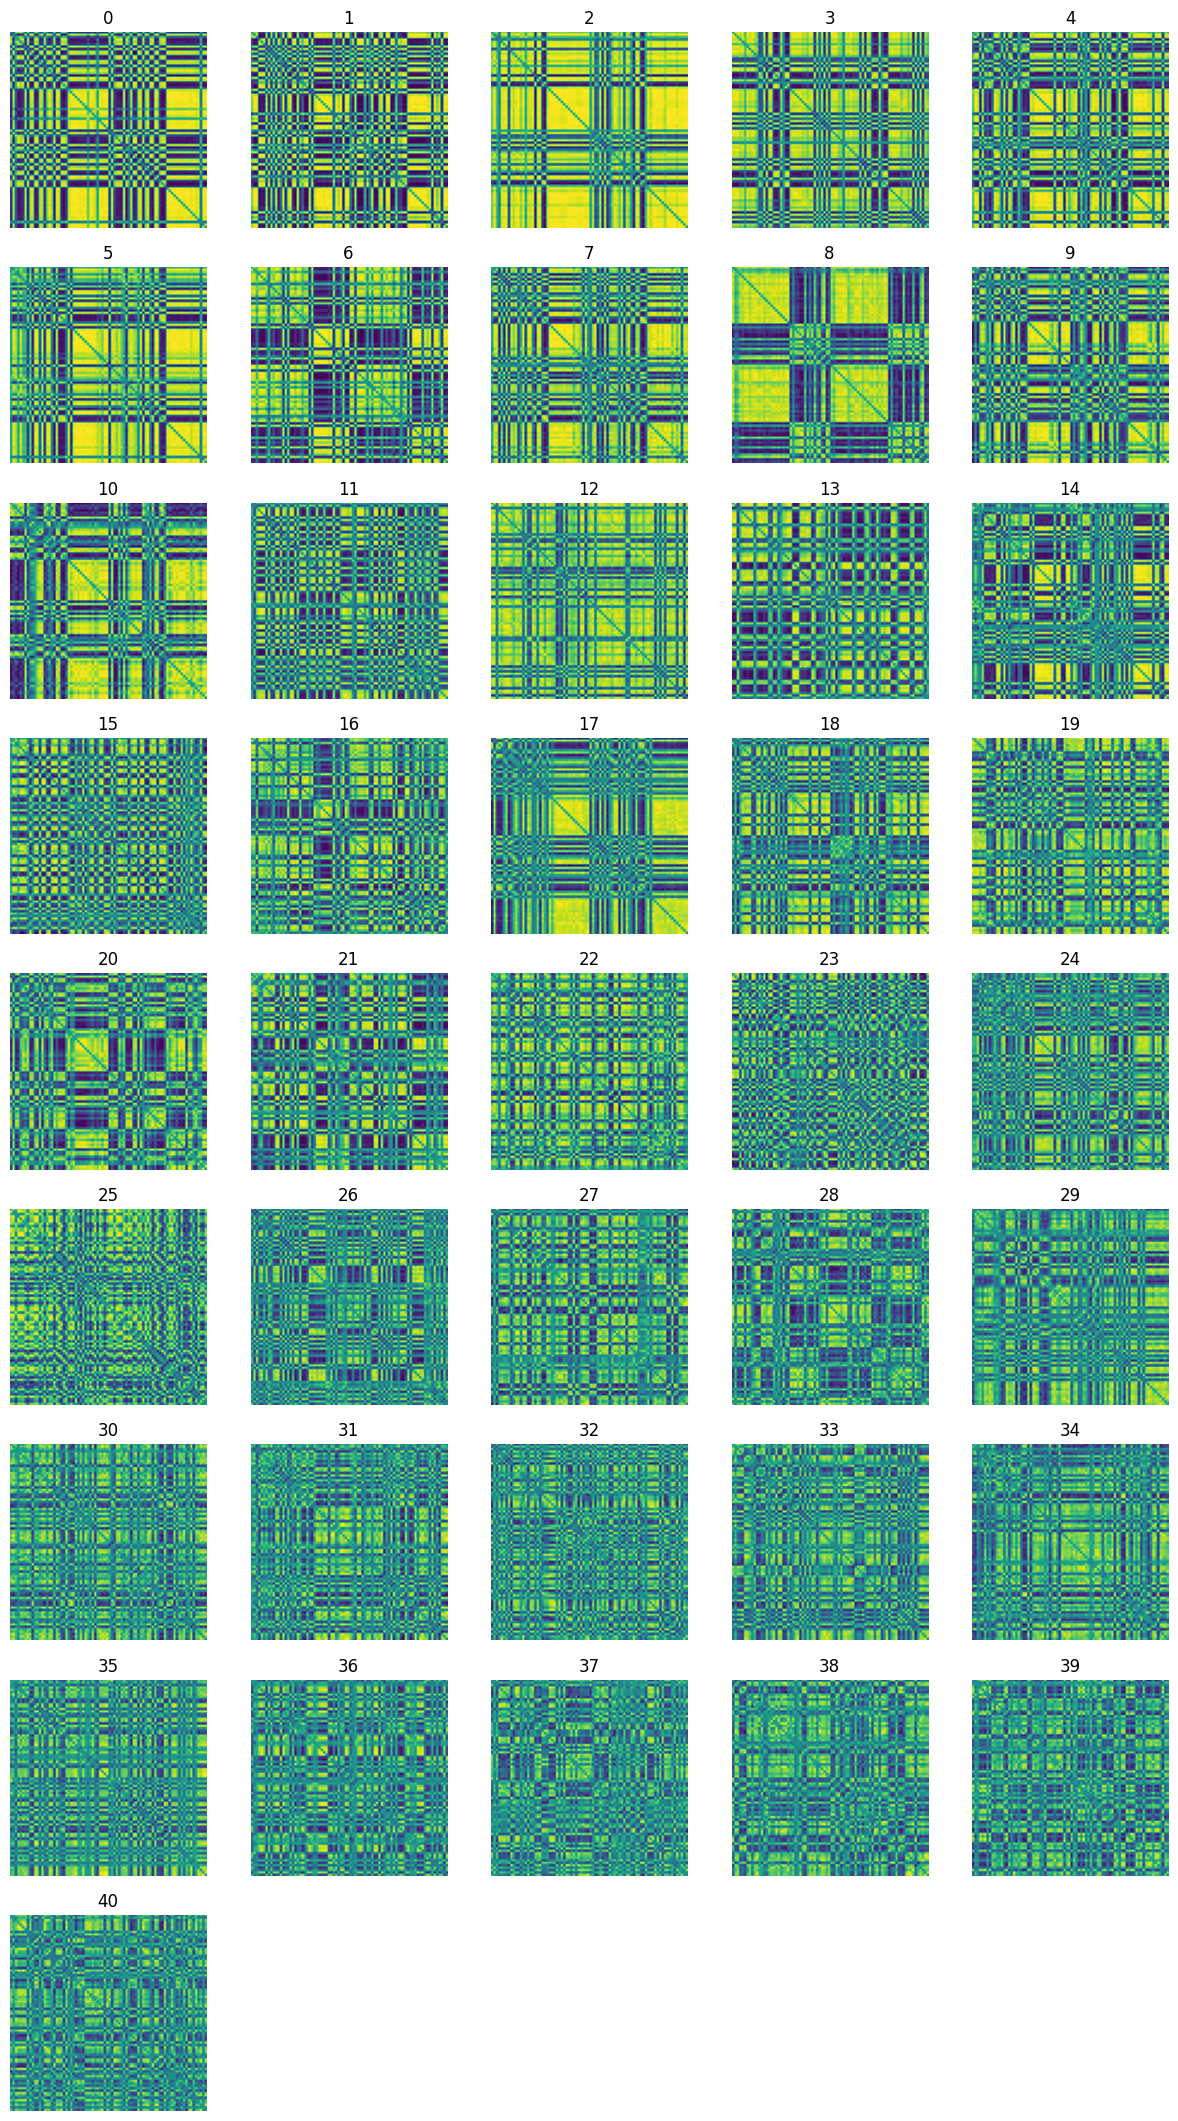

In [154]:
n = len(new_states)
rows = n // 5 + 1
columns = 5
fig = plt.figure(figsize=(15, rows * 3))

for i in range(n):
    fig.add_subplot(rows, columns, i+1)
    # showing image
    plt.imshow(dfc_win[new_states[i][0],new_states[i][1],:,:])
    plt.title(i)
    plt.axis('off')

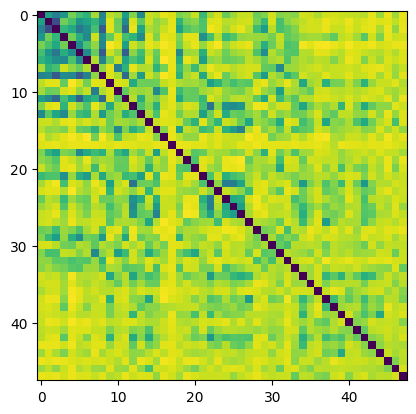

In [34]:
graph_states = compute_graph_states(states)
plt.imshow(graph_states)

In [75]:
union = unionfind.UnionFind(np.arange(len(states)))
for i in range(len(states)):
    for j in range(i,len(states)):
        if graph[states[i,0],states[i,1],states[j,0],states[j,1]] < 0.45 :
            union.union(i,j)

In [76]:
union.components()

[{0},
 {1, 2, 5, 8, 11},
 {3},
 {4},
 {6},
 {7, 10},
 {9},
 {12, 22, 24, 25},
 {13},
 {14},
 {15},
 {16},
 {17},
 {18},
 {19},
 {20},
 {21},
 {23},
 {26},
 {27},
 {28},
 {29},
 {30},
 {31},
 {32},
 {33},
 {34},
 {35},
 {36},
 {37},
 {38},
 {39},
 {40},
 {41},
 {42},
 {43},
 {44},
 {45},
 {46},
 {47}]

In [106]:
new_states_id = []
for set_ in union.components():
    accu_idx = 0
    accu = 0
    for elem in set_:
        session,win = states[elem]
        if np.mean(np.abs(dfc_win[session,win,:,:])) > accu:
            accu_idx = elem
            accu = np.mean(np.abs(dfc_win[session,win,:,:]))
    new_states_id.append(accu_idx)

In [109]:
new_states = np.array([states[id] for id in new_states_id])
new_states = np.load("/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/data/BrainStates/awake_deep-propofol_light-propofol/states_reduced.npy")

## Transitions

In [110]:
graph_states = np.zeros((86,464,2))
for session in range(86):
    for i in range(464):
        l = np.zeros(len(new_states))
        for j in range(len(new_states)):
            l[j] = graph[session,i,new_states[j,0],new_states[j,1]]
        k = np.argmin(l)
        graph_states[session,i] = np.array([int(k),l[k]])

In [155]:
graph_states[31,:,0]

array([18., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18.,
       18., 18., 18., 29., 29., 29., 29., 29., 29., 29., 29., 29., 29.,
       24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24.,
       24., 24., 24., 24., 24.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,
       20., 20., 20.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6., 12., 12.,
       12., 12., 12., 12., 12., 12., 12., 12., 12., 32., 32., 32., 32.,
       32., 32., 32., 32.,  9.,  9.,  9.,  9.,  9.,  9.,  8.,  8.,  0.,
        0.,  0.,  0., 20., 20., 20., 20., 20., 20., 20., 20., 20., 18.,
       18., 18., 18., 18., 18., 18., 18., 18., 18., 18., 18.,  8.,  8.,
        8.,  8.,  8.,  8.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6., 20.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 18.,
       18., 18., 32., 32., 32., 32., 32., 32., 32., 32., 32., 32., 32.,
       32., 18.,  8.,  8., 25., 25., 25., 25., 25.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  9.,  9.,  9.,  9.,  9.,  9.,  9

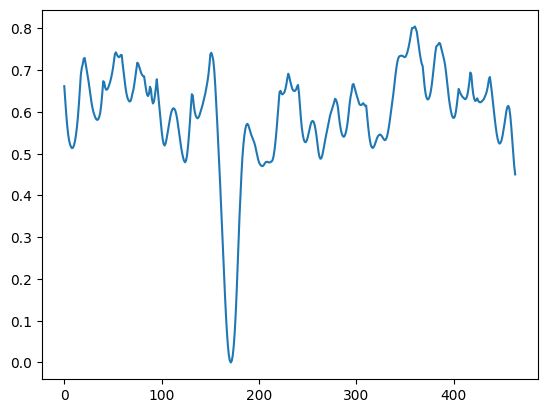

In [165]:
plt.plot(graph_states[5,:,1])
plt.show()

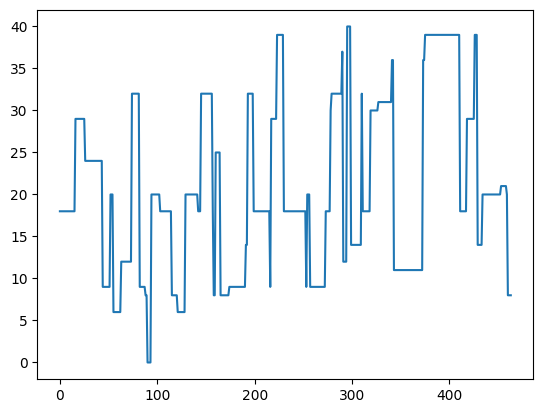

In [158]:
plt.plot(graph_states[31,:,0])
plt.show()

In [134]:
np.argwhere(labels_session == "light-propofol")

array([[31],
       [32],
       [33],
       [34],
       [35],
       [36],
       [37],
       [38],
       [39],
       [40],
       [41],
       [42],
       [43],
       [44],
       [45],
       [46],
       [47],
       [48],
       [49],
       [50],
       [51],
       [52],
       [53],
       [54],
       [55]])

## Torch linear combination